In [7]:
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import colors

import sys
sys.path.insert(0, r'C:\Users\USUARIO\Documents\GitHub')
import hdmpy

import multiprocessing as mp


import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as ols
import statsmodels.formula.api as smf

## 1. Proof of Neyman Orthogonality condition

We have the following linear regression:

$$Y = \alpha D + \beta W' + \epsilon$$

Where: $\alpha$ is the target paramter, $\gamma_{DW}'$ is the estimator of lasso regression D on W and $\gamma_{YW}'$ is the estimator of lasso regression Y on W. On the other hand, $\tilde{Y}$ and $\tilde{D}$ are residuals from the estimation:

$$\tilde{Y} = Y-\gamma_{YW}'W$$

$$\tilde{D} = D- \gamma_{DW}'W$$

Then, we get the vector $\eta^{0}$ with true values:
$$\eta^{0} = (\gamma_{DW}',\gamma_{YW}')'$$

In this case, $\alpha$ is a function of $\eta$, so $\alpha=\alpha(\eta)$ and $\eta=(\eta_{1}',\eta_{2}')$

We want to demonstrate that, in first orden, $\alpha$ is insensitive to local perturbations around the true value $\eta^{0}$.

$$D = \dfrac {\partial \alpha(\eta^{0})}{\partial \eta}=0$$

Let's propose:
$$\tilde{Y} = a \tilde{D} + \mu$$

where $\alpha=\arg\min_{a \in \mathbb R}E(\tilde{Y}-a\tilde{D})^2$. $\alpha$ is the true value of $a$, since $a=\alpha$ solves the equation:

$$E(\tilde{Y}-a\tilde{D})\tilde{D}=0$$

Based on the following condition (equation number 1):

$$M(a,\eta)=E[(\tilde{Y}(\eta_{1})-a\tilde{D}(\eta_{2}))\tilde{D}(\eta_{2})]$$

Where: $\tilde{Y}(\eta_{1})=Y-\eta_{1}'W$ and $\tilde{D}(\eta_{2})=D-\eta_{2}'W$.

Corresponding to the true values $\eta=\eta^{0}$:

$$\tilde{Y}=Y-\gamma_{YW}'W ; \tilde{D}=D-\gamma_{DW}'W$$

By the implicit function theorem:

$$\dfrac {\partial a}{\partial \eta}=-\partial_{a}M(\alpha,\eta^{0})^{-1}\partial_{\eta}M(\alpha,\eta^{0})$$

Remember that we want to demonstrate $\dfrac {\partial \alpha(\eta^{0})}{\partial \eta}=0$

As we observe, the first component $\partial_{a}M(\alpha,\eta^{0})$ can not be zero, so to get what we want, $\partial_{\eta}M(\alpha,\eta^{0})$ must be zero.

The second componet is:

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta}=\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{1}}+\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{2}}$$

Also We will refer to  $\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{1}}$ as $S_{1}$ and   $\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{2}}$ as $S_{2}$

Solving  $S_{1}$ :

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{1}}=E[\dfrac {\partial \tilde{Y}(\eta_{1})}{\partial \eta_{1}}\tilde{D}] $$

As we know: $\tilde{Y} = Y-\eta_{1}'W$

$$\dfrac {\partial \tilde{Y}}{\partial \eta_{1}}=-W $$

Then:

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{1}}=E[-W\tilde{D}]=0$$

Now we solve $S_{2}$:

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{2}}=E[(-a\dfrac {\partial \tilde{D}(\eta_{2})}{\partial \eta_{2}})\tilde{D} + \dfrac {\partial \tilde{D}(\eta_{2})}{\partial \eta_{2}}(\tilde{Y}-a\tilde{D})] $$

As we know: $\tilde{D} = D-\eta_{2}'W$

$$\dfrac {\partial \tilde{D}}{\partial \eta_{2}}=-W $$

Then:

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{2}}=E[-a(-W)\tilde{D}+(-W)(\tilde{Y}-a\tilde{D})] $$

$$\dfrac {\partial M(\alpha,\eta^{0})}{\partial \eta_{2}}=-E(W\tilde{Y})+2E(\alpha W\tilde{D})=0 $$

Thus, we have demonstrated that  $S_{1}=0$ and $S_{2}=0$ are indeed true. Additionally, we have shown that $\dfrac {\partial \alpha(\eta^{0})}{\partial \eta}=0$.



## 2. Orthogonal Learning

$Y = 10*D + beta*X + rnorm(n)$

### B=100

In [2]:
# Set seed
np.random.seed(0)
B = 100
Naive = np.zeros(B)
Orthogonal = np.zeros(B)

In [3]:
for i in range( 0, B ):
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )
    
    # single selection method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()# Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdmpy.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdmpy.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


Text(0.5, 0, 'Naive - True')

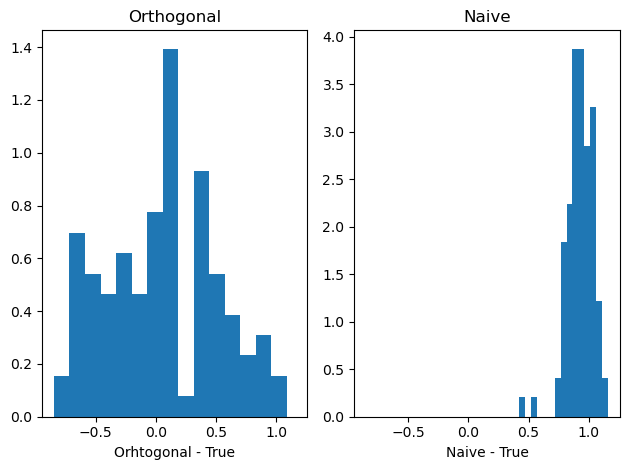

In [4]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , density = True, bins=15)
axs[1].hist( Naive - 10, density = True, bins=15)
#, range = (3, 5)
#, range = (3, 6)

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )

### B=1000

In [5]:
# Set seed
np.random.seed(0)
B = 1000
Naive = np.zeros( B )
Orthogonal = np.zeros( B )

In [ ]:
for i in range( 0, B ):
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 
    # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )
    # single selection method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdmpy.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdmpy.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [ ]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 ,  density = True , bins = 15 )
axs[1].hist( Naive - 10,  density = True , bins = 15 )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )
plt.show()

### B=10000

In [ ]:
# Set seed
np.random.seed(0)
B = 10000
Naive = np.zeros(B)
Orthogonal = np.zeros(B)

In [ ]:
for i in range( 0, B ):
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 
    # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )
    # single selection method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdmpy.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdmpy.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [ ]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 ,  density = True , bins = 15 )
axs[1].hist( Naive - 10,  density = True , bins = 15 )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )
plt.show()

**Comments**

The histograms show that as the number of simulations grows, their distribution increasingly resembles a normal distribution. Ideally, both the orthogonal and naive estimates should be centered on the true value of the estimate. However, due to bias in the naive estimate, its distribution does not center on the true value.

This trend is observed because, as the sample size increases, the distribution tends to cluster around the mean. Moreover, according to the central limit theorem, if a random sample is sufficiently large, the distribution of the sample mean will approximate a normal distribution.

In [ ]:
def run_simulation(i):
    n = 100
    p = 100
    beta = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    gamma = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)

    mean = 0
    sd = 1
    X = np.random.normal(mean, sd, n * p).reshape(n, p)
    D = (X @ gamma) + np.random.normal(mean, sd, n).reshape(n, 1) / 4

    Y = D + (X @ beta) + np.random.normal(mean, sd, n).reshape(n, 1)

    r_lasso_estimation = hdmpy.rlasso(np.concatenate((D, X), axis=1), Y, post=True)
    coef_array = r_lasso_estimation.est['coefficients'].iloc[2:, :].to_numpy()
    SX_IDs = np.where(coef_array != 0)[0]

    if sum(SX_IDs) == 0:
        Naive_result = sm.OLS(Y, sm.add_constant(D)).fit().params[1]
    else:
        X_D = np.concatenate((D, X[:, SX_IDs]), axis=1)
        Naive_result = sm.OLS(Y, sm.add_constant(X_D)).fit().params[1]

    resY = hdmpy.rlasso(X, Y, post=False).est['residuals']
    resD = hdmpy.rlasso(X, D, post=False).est['residuals']
    Orthogonal_result = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]

    return (Naive_result, Orthogonal_result)


In [ ]:
if __name__ == '__main__':
    B = 10  # Número de simulaciones
    pool = mp.Pool(mp.cpu_count())  # Utiliza todos los núcleos disponibles

    results = pool.map(run_simulation, range(B))
    pool.close()
    pool.join()

    # Extrae resultados
    Naive_results = [result[0] for result in results]
    Orthogonal_results = [result[1] for result in results]

    # Ahora podrías analizar estos resultados, por ejemplo, calculando medias o visualizando distribuciones
    print("Naive results:", Naive_results)
    print("Orthogonal results:", Orthogonal_results)


Parallel computing allows for the distribution of work across multiple
processors or processor cores simultaneously. In a sequential
approach, tasks are executed one after another, meaning the total
execution time is simply the sum of the time required for each
individual task. In contrast, with parallel computing, multiple tasks
can be processed at the same time, potentially reducing the overall
time needed to complete all tasks. This allows for more efficient use
of computing resources, significantly speeding up processes that
involve repetitive or data-intensive tasks

## 3. Double Lasso - Using School data

In [57]:
data = pd.read_csv("bruhn2016.csv")

In [110]:
data
# Assuming 'data' is your DataFrame
data.rename(columns={
    'const': 'intercept',
    'outcome.test.score': 'outcome_test_score',
    'treatment': 'treatment',
    'school': 'school',
    'is.female': 'is_female',
    'mother.attended.secondary.school': 'mother_attended_secondary_school',
    'father.attened.secondary.school': 'father_attended_secondary_school',
    'failed.at.least.one.school.year': 'failed_at_least_one_school_year',
    'family.receives.cash.transfer': 'family_receives_cash_transfer',
    'has.computer.with.internet.at.home': 'has_computer_with_internet_at_home',
    'is.unemployed': 'is_unemployed',
    'has.some.form.of.income': 'has_some_form_of_income',
    'saves.money.for.future.purchases': 'saves_money_for_future_purchases',
    'intention.to.save.index': 'intention_to_save_index',
    'makes.list.of.expenses.every.month': 'makes_list_of_expenses_every_month',
    'negotiates.prices.or.payment.methods': 'negotiates_prices_or_payment_methods',
    'financial.autonomy.index': 'financial_autonomy_index'
}, inplace=True)

data = sm.add_constant(data)

data

,intercept,outcome_test_score,treatment,school,is_female,mother_attended_secondary_school,father_attended_secondary_school,failed_at_least_one_school_year,family_receives_cash_transfer,has_computer_with_internet_at_home,...,saves_money_for_future_purchases,intention_to_save_index,makes_list_of_expenses_every_month,negotiates_prices_or_payment_methods,financial_autonomy_index,treatment_missing,is_female_missing,mother_attended_secondary_school_missing,father_attended_secondary_school_missing,has_computer_with_internet_at_home_missing
0,1.0,47.367374,0,17018390,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,29.0,0.0,1.0,52.0,0,0,0,0,0
1,1.0,58.176758,1,33002614,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,41.0,0.0,0.0,27.0,0,0,0,0,0
2,1.0,56.671661,1,35002914,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,48.0,0.0,1.0,56.0,0,0,0,0,0
3,1.0,29.079376,0,35908915,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,42.0,0.0,0.0,27.0,0,0,0,0,0
4,1.0,49.563534,1,33047324,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,50.0,0.0,1.0,31.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17294,1.0,49.489826,1,35012178,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,34.0,0.0,1.0,43.0,0,0,0,0,0
17295,1.0,56.457314,0,35005320,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,15.0,0.0,0.0,35.0,0,0,0,0,0
17296,1.0,59.700623,0,33016070,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,41.0,0.0,0.0,24.0,0,0,0,0,0
17297,1.0,57.515606,0,53007514,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,79.0,0.0,1.0,46.0,0,0,0,0,0


In [111]:
# Calcular el número de elementos por columna
elements_per_column = data.count() + data.isna().sum()

# Calcular el número y porcentaje de NaNs por columna
nans_per_column = data.isna().sum()
percentage_nans_per_column = (nans_per_column / elements_per_column) * 100

# Crear un DataFrame para visualizar los resultados
nan_summary = pd.DataFrame({
    'Total Elements': elements_per_column,
    'Total NaNs': nans_per_column,
    'Percentage of NaNs': percentage_nans_per_column
})

print(nan_summary)


                                            Total Elements  Total NaNs  \
intercept                                            17299           0   
outcome_test_score                                   17299           0   
treatment                                            17299           0   
school                                               17299           0   
is_female                                            17299           0   
mother_attended_secondary_school                     17299           0   
father_attended_secondary_school                     17299           0   
failed_at_least_one_school_year                      17299        1913   
family_receives_cash_transfer                        17299        1749   
has_computer_with_internet_at_home                   17299           0   
is_unemployed                                        17299         789   
has_some_form_of_income                              17299         774   
saves_money_for_future_purchases      

In [112]:
baseline_columns = ['treatment', 'is_female', 'mother_attended_secondary_school', 'father_attended_secondary_school', 'has_computer_with_internet_at_home']  # list your columns here

for column in baseline_columns:
    data[column].fillna(0, inplace=True)
    data[f'{column}_missing'] = data[column].isna().astype(int)


In [113]:
data
# Calcular el número de elementos por columna
elements_per_column = data.count() + data.isna().sum()

# Calcular el número y porcentaje de NaNs por columna
nans_per_column = data.isna().sum()
percentage_nans_per_column = (nans_per_column / elements_per_column) * 100

# Crear un DataFrame para visualizar los resultados
nan_summary = pd.DataFrame({
    'Total Elements': elements_per_column,
    'Total NaNs': nans_per_column,
    'Percentage of NaNs': percentage_nans_per_column
})

print(nan_summary)


                                            Total Elements  Total NaNs  \
intercept                                            17299           0   
outcome_test_score                                   17299           0   
treatment                                            17299           0   
school                                               17299           0   
is_female                                            17299           0   
mother_attended_secondary_school                     17299           0   
father_attended_secondary_school                     17299           0   
failed_at_least_one_school_year                      17299        1913   
family_receives_cash_transfer                        17299        1749   
has_computer_with_internet_at_home                   17299           0   
is_unemployed                                        17299         789   
has_some_form_of_income                              17299         774   
saves_money_for_future_purchases      

In [114]:
# We create the main variables
y = data['outcome_test_score']
x = data[['intercept', 'treatment', 'is_female', 'mother_attended_secondary_school', 'father_attended_secondary_school', 'has_computer_with_internet_at_home']]



In [115]:
x

,intercept,treatment,is_female,mother_attended_secondary_school,father_attended_secondary_school,has_computer_with_internet_at_home
0,1.0,0,0.0,0.0,0.0,0.0
1,1.0,1,0.0,0.0,0.0,0.0
2,1.0,1,1.0,1.0,1.0,0.0
3,1.0,0,1.0,0.0,0.0,0.0
4,1.0,1,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
17294,1.0,1,1.0,1.0,1.0,0.0
17295,1.0,0,1.0,0.0,0.0,1.0
17296,1.0,0,1.0,0.0,0.0,1.0
17297,1.0,0,1.0,1.0,1.0,0.0


In [116]:
reg_ols  = sm.OLS(y, x).fit()
print(reg_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     outcome_test_score   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     163.1
Date:                Tue, 14 May 2024   Prob (F-statistic):          5.54e-170
Time:                        08:43:12   Log-Likelihood:                -70686.
No. Observations:               17299   AIC:                         1.414e+05
Df Residuals:                   17293   BIC:                         1.414e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
inte

In [117]:
# output: estimated regression coefficient corresponding to the target regressor
est_ols = reg_ols.summary2().tables[1]['Coef.']['treatment']

# output: std. error
std_ols = reg_ols.summary2().tables[1]['Std.Err.']['treatment']

# output: 95% confidence interval
lower_ci = reg_ols.summary2().tables[1]['[0.025']['treatment']
upper_ci = reg_ols.summary2().tables[1]['0.975]']['treatment']

In [129]:
table_1 = np.zeros( (1, 4) )

table_1[0,0] = est_ols  
table_1[0,1] = std_ols   
table_1[0,2] = lower_ci
table_1[0,3] = upper_ci    


table_1_pandas = pd.DataFrame( table_1, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ])
table_1_pandas.index = [ "OLS" ]
table_1_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,4.281901,0.219145,3.852355,4.711448


###  2.2.2. Double lasso: cross validation

In [123]:
# Create main variables
Y = data['outcome_test_score']
W = data[['is_female', 'mother_attended_secondary_school', 'father_attended_secondary_school', 'has_computer_with_internet_at_home']]
D = data['treatment']

In [124]:
from sklearn import linear_model

# Seat values for Lasso
lasso_model = linear_model.Lasso( alpha = 0.00077 )
r_Y = Y - lasso_model.fit( W, Y ).predict( W )
r_Y = r_Y.rename('r_Y')

# Part. out d
r_D = D - lasso_model.fit( W, D ).predict( W )
r_D = r_D.rename('r_D')

# ols 
partial_lasso_fit = sm.OLS(r_Y, r_D).fit()

est_lasso = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']
std_lasso = partial_lasso_fit.summary2().tables[1]['Std.Err.']['r_D']
lower_ci_lasso = partial_lasso_fit.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = partial_lasso_fit.summary2().tables[1]['0.975]']['r_D']

In [125]:
# Regress residuales
partial_lasso_fit = sm.OLS(r_Y, r_D).fit()
partial_lasso_est = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']

print( f"Coefficient for D via partialling-out using lasso {partial_lasso_est}" )

Coefficient for D via partialling-out using lasso 4.281753840839821


In [126]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']

# output: std. error
std_lasso = partial_lasso_fit.summary2().tables[1]['Std.Err.']['r_D']

# output: 95% confidence interval
lower_ci_lasso = partial_lasso_fit.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = partial_lasso_fit.summary2().tables[1]['0.975]']['r_D']

In [127]:
table_2 = np.zeros( (1, 4) )

table_2[0,0] = est_lasso  
table_2[0,1] = std_lasso   
table_2[0,2] = lower_ci_lasso
table_2[0,3] = upper_ci_lasso    


table_2_pandas = pd.DataFrame( table_2, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ])
table_2_pandas.index = [ "LASSO" ]
table_2_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
LASSO,4.281754,0.219109,3.852277,4.71123


In [130]:

table_3 = table_1_pandas.append(table_2_pandas)
table_3

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14496\949453284.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_3 = table_1_pandas.append(table_2_pandas)


,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,4.281901,0.219145,3.852355,4.711448
LASSO,4.281754,0.219109,3.852277,4.711230


## 3. Double lasso: Theorical lambda

In [131]:
res_Y = hdmpy.rlasso( W, Y).est['residuals']   # By default Post lasso 
res_D = hdmpy.rlasso( W, D ).est['residuals'] # By default Post lasso 

r_Y = pd.DataFrame(res_Y, columns=['r_Y'])
r_D = pd.DataFrame(res_D, columns=['r_D'])

In [132]:
# OLS regression
reg_ols  = sm.OLS(r_Y, r_D).fit()
print(reg_ols.summary())

#.get_robustcov_results(cov_type = "HC1")

                                 OLS Regression Results                                
Dep. Variable:                    r_Y   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              381.7
Date:                Tue, 14 May 2024   Prob (F-statistic):                    4.30e-84
Time:                        08:53:22   Log-Likelihood:                         -70686.
No. Observations:               17299   AIC:                                  1.414e+05
Df Residuals:                   17298   BIC:                                  1.414e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [134]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso = reg_ols.summary2().tables[1]['Coef.']['r_D']

# output: std. error
std_lasso = reg_ols.summary2().tables[1]['Std.Err.']['r_D']

# output: 95% confidence interval
lower_ci_lasso = reg_ols.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = reg_ols.summary2().tables[1]['0.975]']['r_D']

In [135]:
table_4 = np.zeros( (1, 4) )

table_4[0,0] = est_lasso   
table_4[0,1] = std_lasso    
table_4[0,2] = lower_ci_lasso 
table_4[0,3] = upper_ci_lasso     


table_4_pandas = pd.DataFrame( table_4, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ]) 
table_4_pandas.index = [ "LASSO HDM" ]
table_4_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
LASSO HDM,4.279705,0.219058,3.850329,4.709082


In [136]:
table_s = table_3.append(table_4_pandas)
table_s

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14496\2025223582.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_s = table_3.append(table_4_pandas)


,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,4.281901,0.219145,3.852355,4.711448
LASSO,4.281754,0.219109,3.852277,4.711230
LASSO HDM,4.279705,0.219058,3.850329,4.709082


## 2.2.4. Double Lasso: Partialling out

In [139]:
# Datadframe 

Y = data[['outcome_test_score']]
D = data[['treatment']]

In [140]:

lasso_direct = hdmpy.rlassoEffect(x=W, y=Y, d=D, method="partialling out")  # put as argument method="partialling out"
lasso_direct

{'alpha': 4.2796907,
 'se': array([0.21927322]),
 't': array([19.51761701]),
 'pval': array([7.77823279e-85]),
 'coefficients': 4.2796907,
 'coefficient': 4.2796907,
 'coefficients_reg':                      0
 (Intercept)  56.054419
 x0            3.743114
 x1            1.496441
 x2            1.301405
 x3           -1.141525,
 'selection_index': array([[ True],
        [ True],
        [ True],
        [ True]]),
 'residuals': {'epsilon': array([[ -6.48671462],
         [  0.04297827],
         [ -8.00307806],
         ...,
         [  3.24494496],
         [ -2.879443  ],
         [-30.743454  ]]),
  'v': array([[-0.51413375],
         [ 0.48586622],
         [ 0.48586622],
         ...,
         [-0.51413375],
         [-0.51413375],
         [ 0.48586622]], dtype=float32)},
 'samplesize': 17299}

In [143]:

lasso_direct['alpha']

4.2796907

In [144]:
est_lasso_hdm = lasso_direct['alpha']
std_lasso_hdm = lasso_direct["se"]
lower_ci_lasso_hdm = est_lasso - 1.96*std_lasso
upper_ci_lasso_hdm = est_lasso + 1.96*std_lasso

# t - critical value (DISTRIBUCIÓN NORMAL,  nivel de significancia del 5%)

In [145]:
table_4 = np.zeros( (1, 4) )

table_4[0,0] = est_lasso_hdm   
table_4[0,1] = std_lasso_hdm    
table_4[0,2] = lower_ci_lasso_hdm 
table_4[0,3] = upper_ci_lasso_hdm     


table_4_pandas = pd.DataFrame( table_4, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ]) 
table_4_pandas.index = [ "LASSO_direct" ]
table_4_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
LASSO_direct,4.279691,0.219273,3.850351,4.709059


In [146]:
table_s = table_s.append(table_4_pandas)
table_s

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14496\2194143192.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_s = table_s.append(table_4_pandas)


,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,4.281901,0.219145,3.852355,4.711448
LASSO,4.281754,0.219109,3.852277,4.711230
LASSO HDM,4.279705,0.219058,3.850329,4.709082
LASSO_direct,4.279691,0.219273,3.850351,4.709059


In [147]:
summary=pd.DataFrame(table_s)
summary

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,4.281901,0.219145,3.852355,4.711448
LASSO,4.281754,0.219109,3.852277,4.711230
LASSO HDM,4.279705,0.219058,3.850329,4.709082
LASSO_direct,4.279691,0.219273,3.850351,4.709059


In [148]:
varname=['OLS','LASSO','LASSO HDM','LASSO direct']

In [149]:
summary['varname']=varname
summary


,Estimator,Std. Error,lower bound CI,upper bound CI,varname
OLS,4.281901,0.219145,3.852355,4.711448,OLS
LASSO,4.281754,0.219109,3.852277,4.711230,LASSO
LASSO HDM,4.279705,0.219058,3.850329,4.709082,LASSO HDM
LASSO_direct,4.279691,0.219273,3.850351,4.709059,LASSO direct


In [153]:

summary['err']=(summary['upper bound CI']-summary['lower bound CI'])/2
summary

,Estimator,Std. Error,lower bound CI,upper bound CI,varname,err
OLS,4.281901,0.219145,3.852355,4.711448,OLS,0.429546
LASSO,4.281754,0.219109,3.852277,4.711230,LASSO,0.429476
LASSO HDM,4.279705,0.219058,3.850329,4.709082,LASSO HDM,0.429376
LASSO_direct,4.279691,0.219273,3.850351,4.709059,LASSO direct,0.429354


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14496\818437282.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(summary.shape[0]),


Text(0.5, 1.0, 'Interval confidence of sex coefficient')

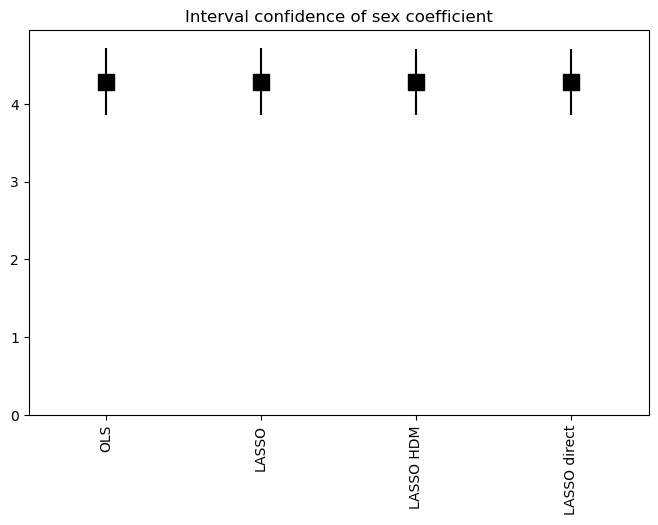

In [156]:
fig, ax = plt.subplots(figsize=(8, 5))
summary.plot(x='varname', y='Estimator', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(summary.shape[0]), 
        marker='s', s=120, 
        y=summary['Estimator'], color='black')
plt.title('Interval confidence of sex coefficient')
